# Data loading

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn import metrics
import lightgbm as lgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [3]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [4]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [5]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip", "train.csv.gzip"]
data_location = "filtered_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')

data_storage["train"]['date'] = pd.to_datetime(data_storage["train"]['date'], format = '%Y-%m-%d')



# Data preporation tools

In [6]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.data_preprocessor import DataPreprocessor

proc = DataPreprocessor(data_storage)

### Feature extraction step

In [7]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm

def expand_dataset_with_zero_sales(df):
    matrix = []
    min_date = df['date'].min()
    
    for date_block in range(df['date_block_num'].min(), df['date_block_num'].max() + 1):
        month_data = df[df['date_block_num'] == date_block]
        shops = month_data['shop_id'].unique()
        items = month_data['item_id'].unique()
        month_start = min_date + pd.tseries.offsets.DateOffset(months=date_block)
        
        matrix.append(np.array(list(product([date_block], [month_start], shops, items))))
        
    df_new = pd.DataFrame(np.vstack(matrix), columns=['date_block_num', 'month_start', 'shop_id', 'item_id'])

    df_agg = df.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg(
        item_cnt_month=('item_cnt_day', 'sum')
    )
    
    df_merged = df_new.merge(df_agg, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    
    df_merged.rename(columns={'item_cnt_month': 'item_cnt_month'}, inplace=True)
    df_merged['item_cnt_month'] = df_merged['item_cnt_month'].clip(0, 20)
    
    df_merged['item_cnt_month'] = df_merged['item_cnt_month'].fillna(0)
    
    
    df_merged['date_block_num'] = df_merged['date_block_num'].astype('int8')
    df_merged['shop_id'] = df_merged['shop_id'].astype('int8')
    df_merged['item_id'] = df_merged['item_id'].astype('int16')
    df_merged['item_cnt_month'] = df_merged['item_cnt_month'].astype('float32')
    
    return df_merged

In [8]:
train = expand_dataset_with_zero_sales(data_storage["train"])

In [9]:
train_with_date = proc.add_month_and_days(train)

train_with_cat_features = proc.add_cat_features(train_with_date)

cat_features = ['shop_city', 'shop_type', 'item_category_type', 'item_category_subtype']

train_with_encoded_cat_features = proc.encode_categorical_features(train_with_cat_features, cat_features=cat_features)

train_with_lag_features = proc.add_lag_features(train_with_encoded_cat_features, time_column='date_block_num',lags=[1, 2, 3],group_level=['shop_id', 'item_id'] ,feature_column='item_cnt_month')

train_without_data_drift = train_with_lag_features[train_with_lag_features['date_block_num'] > 20]


In [10]:
columns_to_exclude = [
                      'month_start',
                      'shop_name',
                      'item_category_name',
                      'item_name'
                     ]

cat_features = ['month',
                'shop_id',
                'shop_city',
                'shop_type',
                'item_category_id',
                'item_category_type',
                'item_category_subtype',
                'days_in_month'
               ]

final_train = train_without_data_drift.drop(columns_to_exclude, axis=1)

In [11]:
final_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,month,days_in_month,item_category_id,item_category_type,item_category_subtype,shop_city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
5589650,21,26,6183,1.0,10,31,24,5,17,12,6,1.0,3.0,1.0
5589651,21,26,11391,1.0,10,31,19,5,10,12,6,0.0,0.0,1.0
5589652,21,26,11389,0.0,10,31,19,5,10,12,6,0.0,0.0,2.0
5589653,21,26,11243,0.0,10,31,37,11,1,12,6,0.0,0.0,0.0
5589654,21,26,11242,0.0,10,31,40,11,4,12,6,0.0,0.0,0.0


In [12]:
%load_ext autoreload
%autoreload 2
from src.validation_schema import TimeSeriesRollingValidator

validator = TimeSeriesRollingValidator(final_train, 'date_block_num', train_window=3, test_window=1)
splits = validator.split_data_rolling()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error

metrics = {
    "RMSE": root_mean_squared_error,
    "MAPE": mean_absolute_percentage_error,
    "R2": r2_score
}

### LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

def model_learning_function(train, val, test, categorical_features):
    X_train = train.drop(columns=['item_cnt_month'])
    y_train = train['item_cnt_month']

    X_val = val.drop(columns=['item_cnt_month'])
    y_val = val['item_cnt_month']

    X_test = test.drop(columns=['item_cnt_month'])
    y_test = test['item_cnt_month']
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    return model

In [15]:
validation_data = validator.validate(model_learning_function, metrics, splits, cat_features, "item_cnt_month")
validation_data

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


,model,train_months,val_months,test_months,dummy_RMSE_test,dummy_MAPE_test,dummy_R2_test,dummy_RMSE_val,dummy_MAPE_val,dummy_R2_val,dummy_RMSE_train,dummy_MAPE_train,dummy_R2_train,model_RMSE_test,model_MAPE_test,model_R2_test,model_RMSE_val,model_MAPE_val,model_R2_val,model_RMSE_train,model_MAPE_train,model_R2_train
0,LinearRegression,740788,236365,231520,1.054480,1.501614,-1.251920e+15,1.214415,1.602357,0.000000e+00,1.379345,1.681021,-2.142130e+15,0.963420,2.952581,-0.848442,0.930875,2.804291,-0.521742,0.977870,11.737343,-0.010425
1,LinearRegression,737918,231520,238948,1.032182,1.443194,-1.199534e+15,1.055544,1.469580,-1.254449e+15,1.392099,1.667887,0.000000e+00,0.796546,1.068738,-0.246109,0.743821,2.199610,0.043655,0.981313,2.264927,0.012297
2,LinearRegression,725406,238948,219268,1.063357,1.432200,-1.273087e+15,1.031340,1.462365,-2.993943e+14,1.333935,1.666791,0.000000e+00,0.795084,2.316321,0.132127,0.764169,2.346212,0.121617,0.919617,4.029693,0.094242
3,LinearRegression,706833,219268,210289,0.995153,1.580076,0.000000e+00,1.058807,1.587728,0.000000e+00,1.101399,1.694768,0.000000e+00,0.733800,1.877069,0.241565,0.781022,1.870888,-0.038857,0.777549,1.827610,0.006432
4,LinearRegression,689736,210289,208649,1.011441,1.678555,0.000000e+00,0.994436,1.657792,-2.783513e+14,1.045675,1.711084,0.000000e+00,0.724854,17.411550,0.185488,0.725710,18.604979,0.198507,0.752183,2.248131,-0.072245
5,LinearRegression,668505,208649,213487,0.971477,1.709672,-2.656471e+14,1.011395,1.717806,-1.151705e+15,1.027433,1.719039,0.000000e+00,0.729599,29.339978,0.023711,0.719500,9.305599,0.092494,0.750655,2.508858,-0.144976
6,LinearRegression,638206,213487,206517,1.036086,1.819045,-1.208624e+15,0.971492,1.726122,0.000000e+00,1.022132,1.721776,0.000000e+00,0.769554,16.113982,-0.700585,0.725520,7.148967,-0.032178,0.738143,2.255144,-0.089934
7,LinearRegression,632425,206517,205779,1.073859,1.744869,-1.298357e+15,1.035998,1.806860,0.000000e+00,0.992373,1.713199,0.000000e+00,0.892934,2.344017,-3.916385,0.772988,2.077599,-0.997111,0.717696,1.898119,-0.096591
8,LinearRegression,628653,205779,218904,1.003262,1.653471,0.000000e+00,1.073853,1.699089,-1.298344e+15,1.006204,1.701234,0.000000e+00,1.001170,1.669228,-1316.455636,0.886117,1.301369,-3.297966,0.733634,2.050319,-0.134935


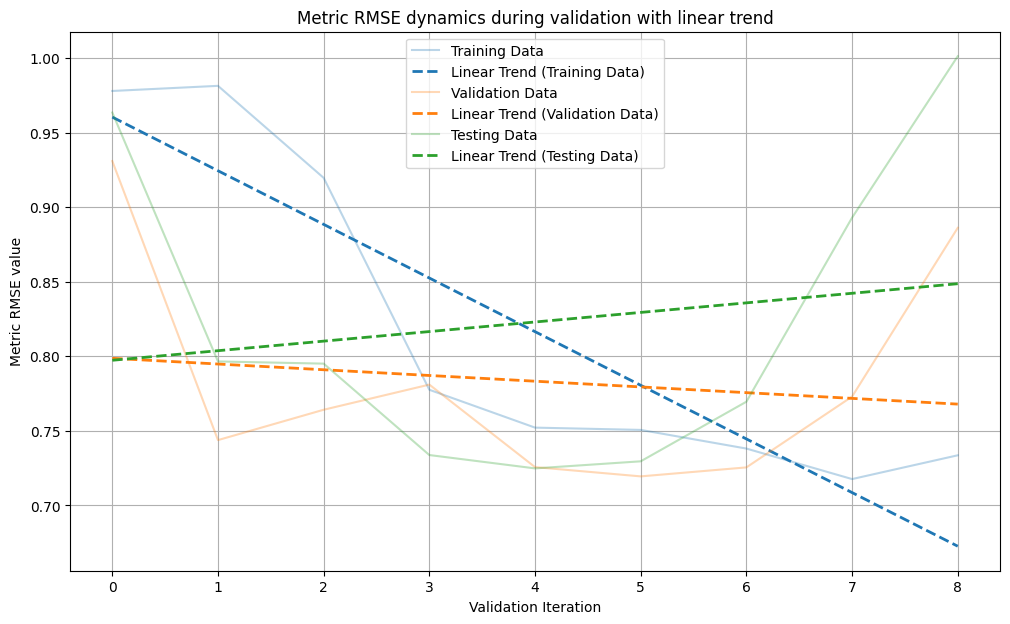

In [16]:

validator.visualize_validation_results_with_linear_trend(validation_data)

In [17]:
from sklearn.svm import SVR

def model_learning_function_svr(train, val, test, categorical_features):
    X_train = train.drop(columns=['item_cnt_month'])
    y_train = train['item_cnt_month']

    X_val = val.drop(columns=['item_cnt_month'])
    y_val = val['item_cnt_month']

    X_test = test.drop(columns=['item_cnt_month'])
    y_test = test['item_cnt_month']
    
    model = SVR(kernel='rbf') 

    model.fit(X_train, y_train)
    return model

In [18]:
# validation_data = validator.validate(model_learning_function_svr, metrics, splits, cat_features, "item_cnt_month")
# validation_data

# svr with 8m dataset size takes to long to compute

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

def model_learning_function_rf(train, val, test, categorical_features):
    X_train = train.drop(columns=['item_cnt_month'])
    y_train = train['item_cnt_month']

    X_val = val.drop(columns=['item_cnt_month'])
    y_val = val['item_cnt_month']

    X_test = test.drop(columns=['item_cnt_month'])
    y_test = test['item_cnt_month']
    
    model = RandomForestRegressor(n_estimators=5, random_state=42)

    model.fit(X_train, y_train)
    return model

In [24]:
validation_data = validator.validate(model_learning_function_rf, metrics, splits, cat_features, "item_cnt_month")
validation_data

100%|██████████| 9/9 [01:33<00:00, 10.43s/it]


,model,train_months,val_months,test_months,dummy_RMSE_test,dummy_MAPE_test,dummy_R2_test,dummy_RMSE_val,dummy_MAPE_val,dummy_R2_val,dummy_RMSE_train,dummy_MAPE_train,dummy_R2_train,model_RMSE_test,model_MAPE_test,model_R2_test,model_RMSE_val,model_MAPE_val,model_R2_val,model_RMSE_train,model_MAPE_train,model_R2_train
0,RandomForestRegressor,740788,236365,231520,1.054480,1.501614,-1.251920e+15,1.214415,1.602357,0.000000e+00,1.379345,1.681021,-2.142130e+15,0.877968,1.946593e+14,0.182097,0.970011,2.027301e+14,0.187559,0.436465,1.209815e+12,0.879937
1,RandomForestRegressor,737918,231520,238948,1.032182,1.443194,-1.199534e+15,1.055544,1.469580,-1.254449e+15,1.392099,1.667887,0.000000e+00,0.890379,2.388370e+14,0.141529,0.846655,2.243824e+14,0.037869,0.444966,1.409820e+12,0.876969
2,RandomForestRegressor,725406,238948,219268,1.063357,1.432200,-1.273087e+15,1.031340,1.462365,-2.993943e+14,1.333935,1.666791,0.000000e+00,0.924840,1.892486e+14,0.078992,0.857611,2.126011e+14,0.118138,0.441588,1.576930e+12,0.867068
3,RandomForestRegressor,706833,219268,210289,0.995153,1.580076,0.000000e+00,1.058807,1.587728,0.000000e+00,1.101399,1.694768,0.000000e+00,0.875860,2.103931e+14,0.248409,0.909975,2.087198e+14,0.042436,0.385128,1.446335e+12,0.849776
4,RandomForestRegressor,689736,210289,208649,1.011441,1.678555,0.000000e+00,0.994436,1.657792,-2.783513e+14,1.045675,1.711084,0.000000e+00,0.855043,2.399989e+14,0.163206,0.844011,2.036256e+14,0.232662,0.365294,1.312420e+12,0.847623
5,RandomForestRegressor,668505,208649,213487,0.971477,1.709672,-2.656471e+14,1.011395,1.717806,-1.151705e+15,1.027433,1.719039,0.000000e+00,0.834565,2.691144e+14,0.049267,0.835304,2.166875e+14,0.082805,0.363564,1.394522e+12,0.843689
6,RandomForestRegressor,638206,213487,206517,1.036086,1.819045,-1.208624e+15,0.971492,1.726122,0.000000e+00,1.022132,1.721776,0.000000e+00,0.846012,2.852408e+14,-0.263378,0.827264,2.385893e+14,0.041421,0.349451,1.474841e+12,0.855846
7,RandomForestRegressor,632425,206517,205779,1.073859,1.744869,-1.298357e+15,1.035998,1.806860,0.000000e+00,0.992373,1.713199,0.000000e+00,0.958790,3.043413e+14,-1.082597,0.876586,2.930479e+14,-0.477560,0.345225,1.474080e+12,0.850757
8,RandomForestRegressor,628653,205779,218904,1.003262,1.653471,0.000000e+00,1.073853,1.699089,-1.298344e+15,1.006204,1.701234,0.000000e+00,1.012384,4.526560e+14,-4.198536,0.916153,2.675297e+14,-0.731909,0.350803,1.361139e+12,0.849003


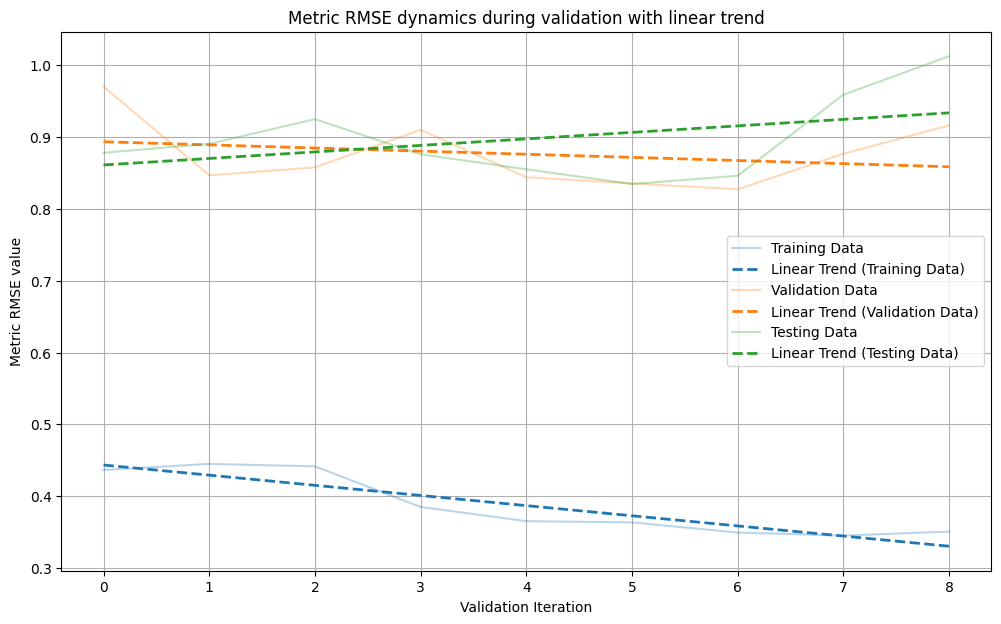

In [25]:

validator.visualize_validation_results_with_linear_trend(validation_data)

## Cat boost model + optuna

In [ ]:
import catboost as cb
from sklearn.metrics import root_mean_squared_error
import optuna
import pandas as pd
import catboost as cb


def get_objective(X_train, y_train, X_val, y_val, categorical_features):
    def objective(trial):
        """
        Целевая функция для Optuna, которая обучается на заданных данных.
        """
        params = {
            'objective': 'RMSE',
            'iterations': trial.suggest_int('iterations', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
            'random_seed': 42,
            'verbose': 0
        }
    
        model = cb.CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=10,
            cat_features=categorical_features
        )
        y_pred = model.predict(X_val)

        rmse = root_mean_squared_error(y_val, y_pred)
        return rmse

    return objective



def model_learning_function(train, val, test, categorical_features):
    X_train = train.drop(columns=['item_cnt_month'])
    y_train = train['item_cnt_month']

    X_val = val.drop(columns=['item_cnt_month'])
    y_val = val['item_cnt_month']

    X_test = test.drop(columns=['item_cnt_month'])
    y_test = test['item_cnt_month']
    
    study = optuna.create_study(direction='minimize')
    study.optimize(get_objective(X_train, y_train,  X_val, y_val, categorical_features), n_trials=5)

    best_params = study.best_trial.params

    X_train_final = pd.concat([X_train, X_val], ignore_index=True)
    y_train_final = pd.concat([y_train, y_val], ignore_index=True)
    
    final_model = cb.CatBoostRegressor(**best_params)

    final_model.fit(X_train_final, y_train_final,
            cat_features=categorical_features, 
            verbose=0)
    
    return final_model

In [ ]:

validation_data = validator.validate(model_learning_function, metrics, splits, cat_features, "item_cnt_month")
validation_data.head(5)


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2025-09-11 12:37:57,487] A new study created in memory with name: no-name-d23b8903-be04-40e4-9e4f-c5a1b3729525
[I 2025-09-11 12:38:02,709] Trial 0 finished with value: 0.8472720621258764 and parameters: {'iterations': 370, 'learning_rate': 0.13014097975693387, 'depth': 4, 'l2_leaf_reg': 6.129664609266122}. Best is trial 0 with value: 0.8472720621258764.
[I 2025-09-11 12:38:16,463] Trial 1 finished with value: 0.8432878661229172 and parameters: {'iterations': 392, 'learning_rate': 0.04766516556388717, 'depth': 7, 'l2_leaf_reg': 0.027990255716663227}. Best is trial 1 with value: 0.8432878661229172.
[I 2025-09-11 12:38:20,192] Trial 2 finished with value: 0.8466783407328864 and parameters: {'iterations': 312, 'learning_rate': 0.2633067943746931, 'depth': 5, 'l2_leaf_reg': 1.690707972875197}. Best is trial 1 with value: 0.8432878661229172.
[I 2025-09-11 12:38:39,988] Trial 3 finished with value: 0.8440477309903451 and parameters: {'iterations': 305, 'learning_rate': 0.04588925850425157,

,model,train_months,val_months,test_months,dummy_RMSE_test,dummy_MAPE_test,dummy_R2_test,dummy_RMSE_val,dummy_MAPE_val,dummy_R2_val,dummy_RMSE_train,dummy_MAPE_train,dummy_R2_train,model_RMSE_test,model_MAPE_test,model_R2_test,model_RMSE_val,model_MAPE_val,model_R2_val,model_RMSE_train,model_MAPE_train,model_R2_train
0,CatBoostRegressor,740788,236365,231520,1.054480,1.501614,-1.251920e+15,1.214415,1.602357,0.000000e+00,1.379345,1.681021,-2.142130e+15,0.733678,6.169493,0.340889,0.785070,1.716110,0.257115,0.841576,13.686165,0.369345
1,CatBoostRegressor,737918,231520,238948,1.032182,1.443194,-1.199534e+15,1.055544,1.469580,-1.254449e+15,1.392099,1.667887,0.000000e+00,0.766917,7.700020,0.008591,0.646916,1.717996,0.367153,0.784039,1.806663,0.508231
2,CatBoostRegressor,725406,238948,219268,1.063357,1.432200,-1.273087e+15,1.031340,1.462365,-2.993943e+14,1.333935,1.666791,0.000000e+00,1.545205,2.256168,-0.210213,0.671515,2.108065,0.214798,0.814451,1.897423,0.376451
3,CatBoostRegressor,706833,219268,210289,0.995153,1.580076,0.000000e+00,1.058807,1.587728,0.000000e+00,1.101399,1.694768,0.000000e+00,0.775101,3.447516,0.237991,0.625733,1.992823,0.410602,0.674717,1.738142,0.356177
4,CatBoostRegressor,689736,210289,208649,1.011441,1.678555,0.000000e+00,0.994436,1.657792,-2.783513e+14,1.045675,1.711084,0.000000e+00,0.742856,3.097282,0.011256,0.607121,1.693788,0.373641,0.637538,1.865484,0.366854


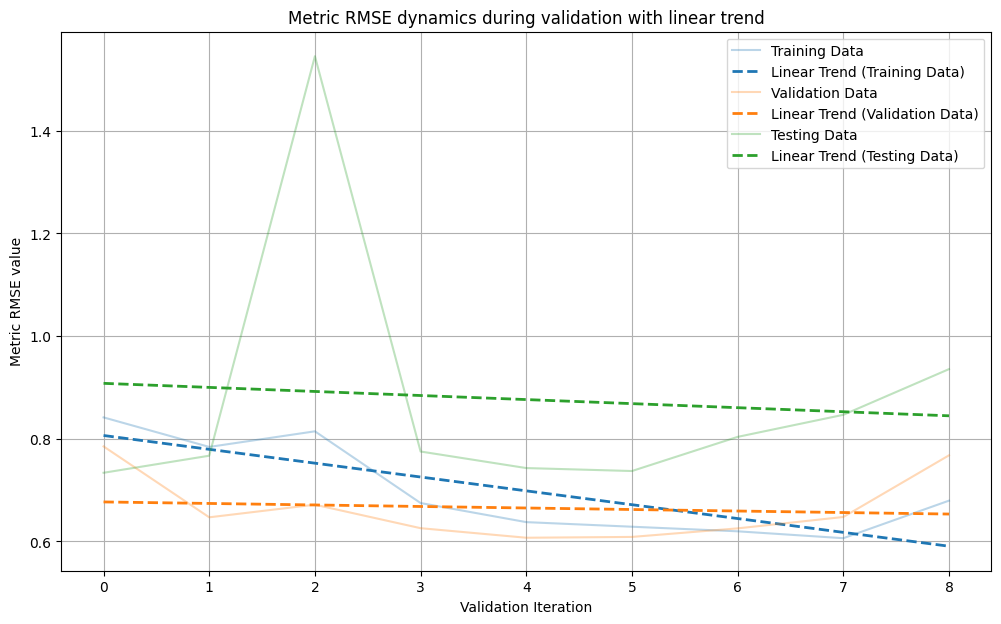

In [30]:
validator.visualize_validation_results_with_linear_trend(validation_data)